In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
# from scipy import optimize as op

In [38]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# df_NP = pd.read_csv('data/Au_NP.txt',sep='\t',header=18)
# df_base = pd.read_csv('data/HAuCl4_solution.txt',sep='\t',header=18)
# df_epsilon = pd.read_csv('data/epsilon_bulk_Au.txt',sep='\t')

# df_NP.to_csv('data/Au_NP.csv',index=False)
# df_base.to_csv('data/HAuCl4_solution.csv', index=False)
# df_epsilon.to_csv('data/epsilon_bulk_Au.csv',index=False)


df_NP = pd.read_csv('data/Au_NP.csv')
df_base = pd.read_csv('data/HAuCl4_solution.csv')
df_epsilon = pd.read_csv('data/epsilon_bulk_Au.csv')

def access(df,lam,key):
    lam_0 = df['lambda'][0]
    i = int(lam - lam_0)
    return df[key][i]

<IPython.core.display.Javascript object>


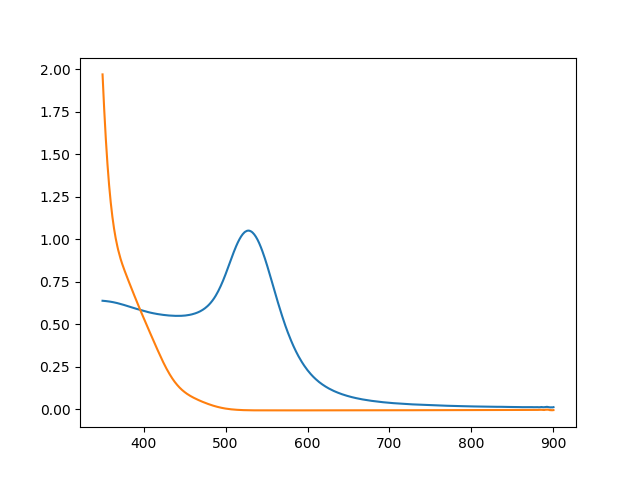

In [3]:
%matplotlib notebook
plt.figure()
plt.plot(df_NP['lambda'],df_NP['A'])
plt.plot(df_base['lambda'],df_base['A'])

<IPython.core.display.Javascript object>


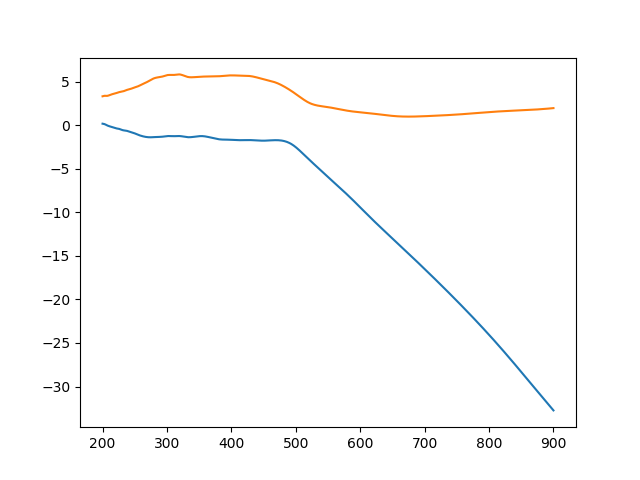

In [45]:
plt.figure()
plt.plot(df_epsilon['lambda'], df_epsilon['eps_1'])
plt.plot(df_epsilon['lambda'], df_epsilon['eps_2'])

In [4]:
z = 0.01*10**9 # thickness of the sample in nm


@np.vectorize
def absorbance(lam, eps_m, f):
    eps_1 = access(df_epsilon,lam,'eps_1')
    eps_2 = access(df_epsilon,lam,'eps_2')
    
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)
    


<IPython.core.display.Javascript object>


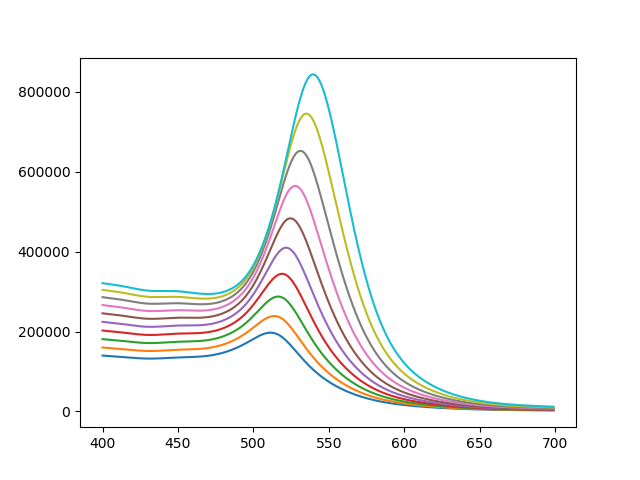

In [7]:
lams = np.arange(400,700)
eps_ms = np.linspace(1.1,1.6,10)**2

plt.figure()
for eps_m in eps_ms:
    As = absorbance(lams,eps_m,1)
    plt.plot(lams,As)

In [5]:
def r_chi2(func, xdata, ydata, args):
    '''
    func(x, *args)
    '''
    ddof = len(xdata) - len(args)
    return np.sum((ydata - func(xdata, *args))**2)/ddof

def make_args_list(args):
    '''
    args is a list of arrays: each of them contains the possible values for that parameter
    '''
    lens = [len(a) for a in args]
    return np.array(np.meshgrid(*args)).T.reshape(np.product(lens),len(lens))


def r_chi2_map(func, xdata, ydata, args_list):
    chi2s = []
    for args in tqdm(args_list):
        chi2s.append(r_chi2(func,xdata,ydata,args))
    return np.array(chi2s)
    

## Without size correction

In [88]:
fs = np.linspace(1.4e-6,2.4e-6,100)
eps_ms = np.linspace(1.9,2.5,100)

lams = np.arange(500,600)
As = np.array([access(df_NP,lam,'A') for lam in lams])

r_chi2s = r_chi2_map(absorbance,lams,As,make_args_list([eps_ms,fs]))

100%|██████████| 10000/10000 [00:41<00:00, 242.24it/s]


In [89]:
print(np.min(r_chi2s))
make_args_list([eps_ms,fs])[np.argmin(r_chi2s)]

0.011306576162362976


array([2.22727273e+00, 1.81414141e-06])

<IPython.core.display.Javascript object>


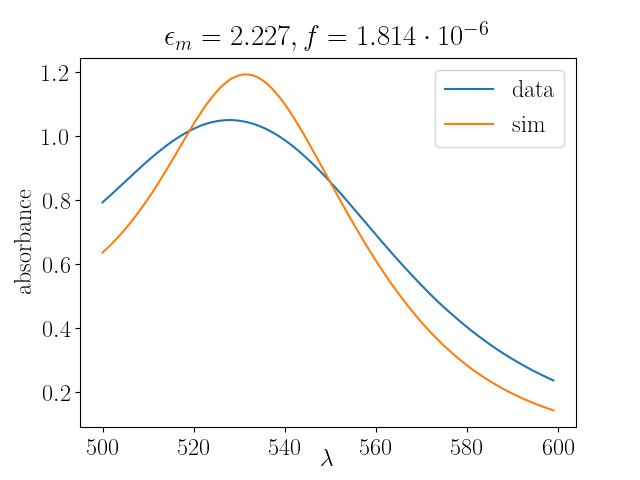

In [90]:
eps_m = 2.227
f = 1.814e-06

name = 'part1_fine_scan_500-600_best'

fig,ax = plt.subplots()
plt.plot(lams,As,label='data')
plt.plot(lams,absorbance(lams,eps_m,f),label='sim')
plt.legend()

plt.xlabel('$\lambda$')
plt.ylabel('absorbance')
plt.title('$\epsilon_m = %.3f, f = %.3f\cdot 10^{-6}$' %(eps_m,10**6*f))
ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

<IPython.core.display.Javascript object>


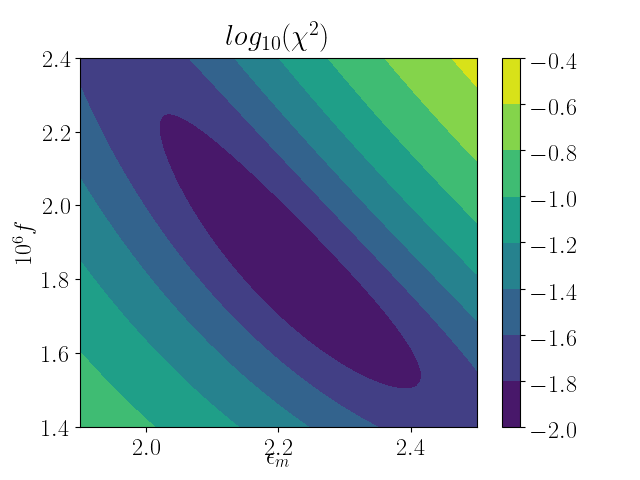

In [92]:
%matplotlib notebook
name = 'part1_fine_scan_500-600'

Eps_m, F = np.meshgrid(eps_ms,fs)


fig,ax = plt.subplots()
plt.contourf(Eps_m,1e6*F,np.log10(r_chi2s.reshape(len(eps_ms),len(fs)).T))
plt.colorbar()

plt.xlabel('$\epsilon_m$')
plt.ylabel('$10^6 f$')
plt.title('$log_{10}(\chi^2)$')

ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')